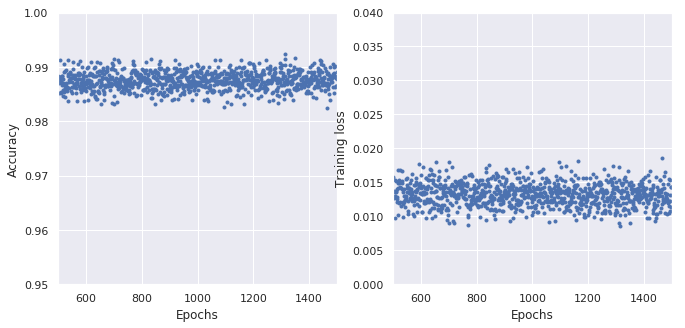

In [2]:
import _pickle as cPickle
import pickle as Pickle
import seaborn as sns
%matplotlib inline
sns.set()
with open('/home/rohan/Dropbox/AllenInstitute/CellCount/dat/results/' + 'Data_v2_Run_v1epochs_1500-summary.pkl', 'rb') as file_pi:
        summary = Pickle.load(file_pi)
plt.figure(figsize=(11,5))
plt.subplot(1,2,1,ylabel='Accuracy',xlabel='Epochs',xlim=(500,1500),ylim=(0.95,1))
plt.plot(summary['acc'],'.')
plt.subplot(1,2,2,ylabel='Training loss',xlabel='Epochs',xlim=(500,1500),ylim=(0,0.04))
plt.plot(summary['loss'],'.')

In [7]:
import os
import pdb
import pickle as Pickle
import sys
import time
import timeit
from random import shuffle


#import keras.activations.softmax as Softmax
import matplotlib.pyplot as plt
import numpy as np
import scipy.io as sio
import tensorflow as tf
from keras import backend as K
from keras.callbacks import LearningRateScheduler, ModelCheckpoint
from keras.layers import (Concatenate, Conv2D, Cropping2D, Dropout, Input,
                          MaxPooling2D, UpSampling2D, Dense, Activation)
from keras.losses import binary_crossentropy, mean_squared_error
from keras.models import Model
from keras.optimizers import Adam
from keras.utils import plot_model

import _pickle as cPickle
import fileIO
import im3dscroll as I
from custom_dataloader import DataGenerator
from dataclass import dataset, combine_patches
import pdb


runmode = 'train-new'#viewresult or train-new

archid = 'Data_v2_Run_v1'
nepochs = 1500
batch_size = 4
patchsize = 128
save_period = 50

viewrunid = 'Data_v2_Run_v1'
base_path, rel_im_path, rel_lbl_path, rel_result_path = fileIO.set_paths()[0:4]
runid = archid + 'epochs_' + str(nepochs) #+ time.strftime("%Y%m%d-%H%M%S")


#Training data 
train_fileid = ['268778_157', '268778_77',
                '271317_143', '271317_95',
                '275376_147', '275376_175',
                '275705_109', '275705_131',
                '279578_111', '279578_123',
                '299769_119', '299769_167',
                '299773_57', '299773_68',
                '301199_74', '315576_116',
                '316809_60', '324471_113',
                '371808_52', '386384_47',
                '387573_103_1', '389052_108',
                '389052_119']

train_data = dataset(train_fileid, batch_size=batch_size, patchsize=patchsize,
                        getpatch_algo='random', npatches=10**2, fgfrac=.5,
                        shuffle=True, rotate=True, flip=True)
train_data.load_im_lbl()
train_generator = DataGenerator(train_data)


#Validation data 
val_fileid = ['330689_118', '371808_60',
              '387573_103', '324471_53','333241_113']
val_data = dataset(val_fileid, batch_size=batch_size, patchsize=patchsize,
                      getpatch_algo='stride', stride=(64, 64), padding=True,
                      shuffle=False, rotate=False, flip=False)
val_data.load_im_lbl()
val_im,val_lbl = val_data.get_patches() #Validation data is not updated while training.

#Define model
conv_properties = {'activation': 'relu', 'padding': 'same', 'kernel_initializer': 'he_normal'}
input_im = Input(shape=(128, 128, 1), name='input_im')

conv1 = Conv2D(8, 3, **conv_properties)(input_im)   # (batch, 128,128,8)
pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)	    # (batch, 64, 64, 8)

conv2 = Conv2D(8, 3, **conv_properties)(pool1)      # (batch, 64, 64, 8)
pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)	    # (batch, 32, 32, 8)

conv3 = Conv2D(4, 3, **conv_properties)(pool2)		# (batch, 32, 32, 4)
pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)	    # (batch, 16, 16, 4)

conv4 = Conv2D(4, 3, **conv_properties)(pool3)		# (batch, 16, 16, 4)
drop4 = Dropout(0.2)(conv4)						    # (batch, 16, 16, 4)
pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)	    # (batch, 8, 8, 4)

conv5 = Conv2D(4, 3, **conv_properties)(pool4)		# (batch, 8, 8, 4)
drop5 = Dropout(0.2)(conv5)						    # (batch, 8, 8, 4)

up6 = UpSampling2D(size=(2, 2))(drop5)			    # (batch, 16, 16, 4)
up6 = Conv2D(4, 2, **conv_properties)(up6)		    # (batch, 16, 16, 4)
cat6 = Concatenate(axis=3)([drop4, up6])  		    # (batch, 16, 16, 4)
conv6 = Conv2D(4, 3, **conv_properties)(cat6)		# (batch, 16, 16, 4)

up7 = UpSampling2D(size=(2, 2))(conv6)			    # (batch, 32, 32, 4)
up7 = Conv2D(4, 2, **conv_properties)(up7)		    # (batch, 32, 32, 4)
cat7 = Concatenate(axis=3)([conv3, up7])		    # (batch, 32, 32, 8)
conv7 = Conv2D(4, 3, **conv_properties)(cat7)		# (batch, 32, 32, 4)

up8 = UpSampling2D(size=(2, 2))(conv7)			    # (batch, 64, 64, 4)
up8 = Conv2D(8, 2, **conv_properties)(up8)		    # (batch, 64, 64, 8)
cat8 = Concatenate(axis=3)([conv2, up8])  		    # (batch, 64, 64, 16)
conv8 = Conv2D(8, 3, **conv_properties)(cat8)		# (batch, 64, 64, 8)

up9 = UpSampling2D(size=(2, 2))(conv8)			    # (batch, 128,128, 8)
up9 = Conv2D(8, 2, **conv_properties)(up9)		    # (batch, 128,128, 8)
cat9 = Concatenate(axis=3)([conv1, up9])  		    # (batch, 128,128, 16)
conv9 = Conv2D(8, 3, **conv_properties)(cat9)		# (batch, 128,128, 8) 


output_im = Conv2D(3,1, activation='softmax', name='output_im')(conv9)
model = Model(inputs=[input_im], outputs=[output_im])

def loss_fcn_wbce(y_true, y_pred):
    lbl = y_true
    pred = y_pred
    weights = tf.stop_gradient(1. - tf.reduce_mean(lbl, axis=[0, 1, 2]))
    ce = - tf.multiply(lbl, tf.log(pred + K.epsilon())) - tf.multiply((1. - lbl), tf.log(1. - pred + K.epsilon()))
    weighted_ce = tf.multiply(weights, ce)
    return K.mean(weighted_ce, axis=None)

#Load weights
model.load_weights(base_path + rel_result_path + 'Data_v2_Run_v1epochs_1500' + '/' + '1500' + '.h5')



In [8]:
#Original prediction method. There is no overlap between patches while prediction; this suffers from 
#Load dataset
#train_fileid
#val_fileid
imlist = ['324471_53']
for imid in imlist:
    D = dataset([imid], batch_size=4, patchsize=patchsize, getpatch_algo='stride',
        shuffle=False, rotate=False, flip=False, stride=(patchsize,patchsize), padding=True)
    D.load_im_lbl()
    val_im,val_lbl = D.get_patches()

    val_im_90 = np.rot90(val_im, k=1, axes=(1,2))
    val_im_180 = np.rot90(val_im, k=2, axes=(1,2))
    val_im_270 = np.rot90(val_im, k=3, axes=(1,2))

    val_lbl_pred = model.predict(val_im, batch_size=1, verbose=1)
    val_lbl_pred_90 = model.predict(val_im_90, batch_size=1, verbose=1)
    val_lbl_pred_180 = model.predict(val_im_180, batch_size=1, verbose=1)
    val_lbl_pred_270 = model.predict(val_im_270, batch_size=1, verbose=1)

    val_lbl_pred_90 = np.rot90(val_lbl_pred_90, k=3, axes=(1,2))
    val_lbl_pred_180 = np.rot90(val_lbl_pred_180, k=2, axes=(1,2))
    val_lbl_pred_270 = np.rot90(val_lbl_pred_270, k=1, axes=(1,2))

    val_lbl_pred = (val_lbl_pred+val_lbl_pred_90+val_lbl_pred_180+val_lbl_pred_270)/4

    val_lbl_bg = np.expand_dims(val_lbl_pred[:,:,:,0],axis=3)
    val_lbl_bo = np.expand_dims(val_lbl_pred[:,:,:,1],axis=3)
    val_lbl_fg = np.expand_dims(val_lbl_pred[:,:,:,2],axis=3)
    val_lbl_predicted = np.expand_dims(np.argmax(val_lbl_pred, axis=3),axis=3)

    val_lbl_full = combine_patches(val_lbl,patchsize=D.patchsize,stride=D.stride,imsize=D.im_buffer[0].shape,padding=True)
    val_im_full = combine_patches(val_im,patchsize=D.patchsize,stride=D.stride,imsize=D.im_buffer[0].shape,padding=True)

    #lbl_pred_full = combine_patches(val_lbl_pred,patchsize=D.patchsize,stride=D.stride,imsize=D.im_buffer[0].shape,padding=True)
    val_lbl_fg = combine_patches(val_lbl_fg,patchsize=D.patchsize,stride=D.stride,imsize=D.im_buffer[0].shape,padding=True)
    val_lbl_bo = combine_patches(val_lbl_bo,patchsize=D.patchsize,stride=D.stride,imsize=D.im_buffer[0].shape,padding=True)
    val_lbl_predicted = combine_patches(val_lbl_predicted,patchsize=D.patchsize,stride=D.stride,imsize=D.im_buffer[0].shape,padding=True)

    sio.savemat('/home/rohan/Desktop/' +'seg'+imid+'.mat',{'bo':val_lbl_bo,'fg':val_lbl_fg,'im':val_im_full})

400/400 [==============================] - 2s 4ms/step


In [16]:
#New prediction method. Inner pad is hard coded to be ~cell size.
from dataclass import combine_inpadded_patches
#Load dataset
#train_fileid
#val_fileid
imlist = train_fileid+val_fileid
for imid in imlist:
    D = dataset([imid], batch_size=50, patchsize=patchsize, getpatch_algo='inpadded',
        shuffle=False, rotate=False, flip=False, stride=(patchsize,patchsize), padding=True)
    D.load_im_lbl()
    val_im,val_lbl = D.get_patches()

    val_im_90 = np.rot90(val_im, k=1, axes=(1,2))
    val_im_180 = np.rot90(val_im, k=2, axes=(1,2))
    val_im_270 = np.rot90(val_im, k=3, axes=(1,2))

    val_lbl_pred = model.predict(val_im, batch_size=1, verbose=1)
    val_lbl_pred_90 = model.predict(val_im_90, batch_size=1, verbose=1)
    val_lbl_pred_180 = model.predict(val_im_180, batch_size=1, verbose=1)
    val_lbl_pred_270 = model.predict(val_im_270, batch_size=1, verbose=1)

    val_lbl_pred_90 = np.rot90(val_lbl_pred_90, k=3, axes=(1,2))
    val_lbl_pred_180 = np.rot90(val_lbl_pred_180, k=2, axes=(1,2))
    val_lbl_pred_270 = np.rot90(val_lbl_pred_270, k=1, axes=(1,2))

    val_lbl_pred = (val_lbl_pred+val_lbl_pred_90+val_lbl_pred_180+val_lbl_pred_270)/4

    val_lbl_bg = np.expand_dims(val_lbl_pred[:,:,:,0],axis=3)
    val_lbl_bo = np.expand_dims(val_lbl_pred[:,:,:,1],axis=3)
    val_lbl_fg = np.expand_dims(val_lbl_pred[:,:,:,2],axis=3)
    val_lbl_predicted = np.expand_dims(np.argmax(val_lbl_pred, axis=3),axis=3)

    val_lbl_full = combine_inpadded_patches(val_lbl,patchsize=D.patchsize,imsize=D.im_buffer[0].shape,padding=True)
    val_im_full =  combine_inpadded_patches(val_im,patchsize=D.patchsize, imsize=D.im_buffer[0].shape,padding=True)

    #lbl_pred_full = combine_patches(val_lbl_pred,patchsize=D.patchsize,stride=D.stride,imsize=D.im_buffer[0].shape,padding=True)
    val_lbl_fg =        combine_inpadded_patches(val_lbl_fg,patchsize=D.patchsize,imsize=D.im_buffer[0].shape,padding=True)
    val_lbl_bo =        combine_inpadded_patches(val_lbl_bo,patchsize=D.patchsize,imsize=D.im_buffer[0].shape,padding=True)
    val_lbl_predicted = combine_inpadded_patches(val_lbl_predicted,patchsize=D.patchsize,imsize=D.im_buffer[0].shape,padding=True)

    sio.savemat('/home/rohan/Desktop/' +'seg'+imid+'.mat',{'bo':val_lbl_bo[0:2500,0:2500],'fg':val_lbl_fg[0:2500,0:2500],'im':val_im_full[0:2500,0:2500]})

625/625 [==============================] - 2s 4ms/step


In [15]:
val_lbl_bo[0:2500,0:2500].shape

(2500, 2500)

In [5]:
D.im_buffer[0].shape

(2500, 2500)